In [1]:
import os
from typing import Union, Optional

import torch.cuda
from torch.backends import cudnn

from nnunetv2.run.run_training import get_trainer_from_args, maybe_load_checkpoint

os.environ["CUDA_VISIBLE_DEVICES"] = "1"


dataset_name_or_id: Union[str, int] = '213'
configuration: str = '3d_fullres_changedSoftmaxAxis'
fold: Union[int, str] = 0
trainer_class_name: str = 'nnUNetTrainer_noMirroringAxis2redRot'

pretrained = os.path.join(os.environ['nnUNet_results'], f'Dataset213_ONKOI-all-from-208/{trainer_class_name}__nnUNetPlans__{configuration}/fold_{fold}/checkpoint_best.pth')

plans_identifier: str = 'nnUNetPlans'
pretrained_weights: Optional[str] = pretrained
num_gpus: int = 1
use_compressed_data: bool = False
export_validation_probabilities: bool = False
continue_training: bool = False
only_run_validation: bool = False
disable_checkpointing: bool = False
device: torch.device = torch.device('cuda')
num_epochs: int = 1000

if isinstance(fold, str):
    if fold != 'all':
        try:
            fold = int(fold)
        except ValueError as e:
            print(f'Unable to convert given value for fold to int: {fold}. fold must bei either "all" or an integer!')
            raise e

nnunet_trainer = get_trainer_from_args(dataset_name_or_id, configuration, fold, trainer_class_name,
                                        plans_identifier, use_compressed_data, device=device, num_epochs=num_epochs)

if disable_checkpointing:
    nnunet_trainer.disable_checkpointing = disable_checkpointing

assert not (continue_training and only_run_validation), f'Cannot set --c and --val flag at the same time. Dummy.'

maybe_load_checkpoint(nnunet_trainer, continue_training, only_run_validation, pretrained_weights)

if torch.cuda.is_available():
    cudnn.deterministic = False
    cudnn.benchmark = True

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Number of trainable/total parameters in M: 54.02/54.02
################### Loading pretrained weights from file  /data/nnUnet/nnUNet_trained_models/Dataset213_ONKOI-all-from-208/nnUNetTrainer_noMirroringAxis2redRot__nnUNetPlans__3d_fullres_changedSoftmaxAxis/fold_0/checkpoint_best.pth ###################
Below is the list of overlapping blocks in pretrained model and nnUNet architecture:
encoder.stages.0.0.0.convs.0.conv.weight shape torch.Size([32, 1, 1, 3, 3])
encoder.stages.0.0.0.convs.0.conv.bias shape torch.Size([32])
encoder.stages.0.0.0.convs.0.norm.weight shape 

In [2]:
import numpy as np
nnunet_trainer.on_train_start()
nnunet_trainer.on_validation_epoch_start()
# data = next(nnunet_trainer.dataloader_val)

fn = '/media/medical/gasperp/projects/nnUnetv2_clone/nnUNet/nnunetv2/inference/test_patch.npz'
# with open(fn, 'wb') as f:
#     np.savez(f, data=data['data'].cpu().numpy(), target=data['target'][0].cpu().numpy())
ddd = np.load(fn)
data = {'data': torch.from_numpy(ddd['data']), 'target': [torch.from_numpy(ddd['target'])]}


This is the configuration used by this training:
Configuration name: 3d_fullres_changedSoftmaxAxis
 {'data_identifier': 'nnUNetPlans_3d_fullres', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 2, 'patch_size': [40, 192, 224], 'median_image_size_in_voxels': [94.0, 459.5, 466.0], 'spacing': [2.0, 0.5, 0.5], 'normalization_schemes': ['CTNormalization', 'ZScoreNormalization'], 'use_mask_for_norm': [False, False], 'UNet_class_name': 'PlainConvUNetSeparateEncoderCMX_changedSoftmaxAxis', 'UNet_base_num_features': 32, 'n_conv_per_stage_encoder': [2, 2, 2, 2, 2, 2], 'n_conv_per_stage_decoder': [2, 2, 2, 2, 2], 'num_pool_per_axis': [3, 5, 5], 'pool_op_kernel_sizes': [[1, 1, 1], [1, 2, 2], [1, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]], 'conv_kernel_sizes': [[1, 3, 3], [1, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]], 'unet_max_num_features': 320, 'resampling_fn_data': 'resample_data_or_seg_to_shape', 'resampling_fn_seg': 'resample_data_or_seg_to_shape', 'resampling_fn_data_kwargs'

In [3]:
nnunet_trainer.network.encoder.FFMs_stage1[0].cross.heads[0].key0

Linear(in_features=32, out_features=16, bias=False)

In [4]:
def setup_hooks(d):
    # Visualize feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            if isinstance(output, torch.Tensor):
                activation[name] = output.detach().cpu().numpy()
            elif isinstance(output, (tuple, list)):
                for enum, o in enumerate(output):
                    activation[name + f'_{enum}'] = o.detach().cpu().numpy()
            else:
                print(f'Unknown output type: {type(output)}')
        return hook

    hooks = []

    hooks.append(nnunet_trainer.network.encoder.stages[0][0][0].convs[1].register_forward_hook(get_activation('skip0_CT')))
    hooks.append(nnunet_trainer.network.encoder.stages[1][0][0].convs[1].register_forward_hook(get_activation('skip1_CT')))
    hooks.append(nnunet_trainer.network.encoder.stages[2][0][0].convs[1].register_forward_hook(get_activation('skip2_CT')))
    hooks.append(nnunet_trainer.network.encoder.stages[3][0][0].convs[1].register_forward_hook(get_activation('skip3_CT')))
    hooks.append(nnunet_trainer.network.encoder.stages[4][0][0].convs[1].register_forward_hook(get_activation('skip4_CT')))

    hooks.append(nnunet_trainer.network.encoder.stages[0][1][0].convs[1].register_forward_hook(get_activation('skip0_MR')))
    hooks.append(nnunet_trainer.network.encoder.stages[1][1][0].convs[1].register_forward_hook(get_activation('skip1_MR')))
    hooks.append(nnunet_trainer.network.encoder.stages[2][1][0].convs[1].register_forward_hook(get_activation('skip2_MR')))
    hooks.append(nnunet_trainer.network.encoder.stages[3][1][0].convs[1].register_forward_hook(get_activation('skip3_MR')))
    hooks.append(nnunet_trainer.network.encoder.stages[4][1][0].convs[1].register_forward_hook(get_activation('skip4_MR')))
    
    hooks.append(nnunet_trainer.network.encoder.FRMs[0].register_forward_hook(get_activation('FRM_0')))
    hooks.append(nnunet_trainer.network.encoder.FRMs[1].register_forward_hook(get_activation('FRM_1')))
    hooks.append(nnunet_trainer.network.encoder.FRMs[2].register_forward_hook(get_activation('FRM_2')))
    hooks.append(nnunet_trainer.network.encoder.FRMs[3].register_forward_hook(get_activation('FRM_3')))
    hooks.append(nnunet_trainer.network.encoder.FRMs[4].register_forward_hook(get_activation('FRM_4')))
    
    hooks.append(nnunet_trainer.network.decoder.stages[0].convs[1].nonlin.register_forward_hook(get_activation('decoder0')))
    hooks.append(nnunet_trainer.network.decoder.stages[1].convs[1].nonlin.register_forward_hook(get_activation('decoder1')))
    hooks.append(nnunet_trainer.network.decoder.stages[2].convs[1].nonlin.register_forward_hook(get_activation('decoder2')))
    hooks.append(nnunet_trainer.network.decoder.stages[3].convs[1].nonlin.register_forward_hook(get_activation('decoder3')))
    hooks.append(nnunet_trainer.network.decoder.stages[4].convs[1].nonlin.register_forward_hook(get_activation('decoder4')))
    hooks.append(nnunet_trainer.network.decoder.seg_layers[4].register_forward_hook(get_activation('pred_seg')))


    # output = nnunet_trainer.network.encoder(d[:,[0]], d[:,[1]])
    nnunet_trainer.network.eval()
    output = nnunet_trainer.network(d)

    for h in hooks:
        h.remove()
        
    return activation

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
"""
nnunet_trainer.network.encoder.stages 0-5
each stage in encoder has two branches: CT and MR 0-1
each branch has a single StackedConvBlocks (double-conv) block, so 0
"""

d = data['data'][[0]].to('cuda:0')
activation = setup_hooks(d)

In [6]:
for k in list(activation.keys()):
    if isinstance(activation[k], (list, tuple)):
        print(k, len(activation[k]), activation[k][0].shape)
    else:
        print(k, activation[k].shape)

skip0_CT (1, 32, 40, 192, 224)
skip0_MR (1, 32, 40, 192, 224)
FRM_0_0 (1, 32, 40, 192, 224)
FRM_0_1 (1, 32, 40, 192, 224)
skip1_CT (1, 64, 40, 96, 112)
skip1_MR (1, 64, 40, 96, 112)
FRM_1_0 (1, 64, 40, 96, 112)
FRM_1_1 (1, 64, 40, 96, 112)
skip2_CT (1, 128, 40, 48, 56)
skip2_MR (1, 128, 40, 48, 56)
FRM_2_0 (1, 128, 40, 48, 56)
FRM_2_1 (1, 128, 40, 48, 56)
skip3_CT (1, 256, 20, 24, 28)
skip3_MR (1, 256, 20, 24, 28)
FRM_3_0 (1, 256, 20, 24, 28)
FRM_3_1 (1, 256, 20, 24, 28)
skip4_CT (1, 320, 10, 12, 14)
skip4_MR (1, 320, 10, 12, 14)
FRM_4_0 (1, 320, 10, 12, 14)
FRM_4_1 (1, 320, 10, 12, 14)
decoder0 (1, 320, 10, 12, 14)
decoder1 (1, 256, 20, 24, 28)
decoder2 (1, 128, 40, 48, 56)
decoder3 (1, 64, 40, 96, 112)
decoder4 (1, 32, 40, 192, 224)
pred_seg (1, 31, 40, 192, 224)


In [7]:
[i.shape for i in data['target']]

[torch.Size([2, 1, 40, 192, 224])]

In [8]:
# write me a function to plot activation maps in two rows, 1. row should be the max projection, 2. row should be the mean projection
# the function should take the activation dict and the name of the layer as input

def plot(activation, t, B, SLC, img):
    fig, axes = plt.subplots(3, len(activation)+2, figsize=(25, 4))

    for i, key in enumerate(activation.keys()):
        if key == 'pred_seg':
            FM = activation[key][B][1:]
        else:
            FM = activation[key][B]
        axes[0,i].imshow(FM.max(0)[SLC], cmap='gray')
        axes[1,i].imshow(FM.mean(0)[SLC], cmap='gray')
        axes[2,i].imshow(FM.std(0)[SLC], cmap='gray')
        axes[0,i].set_title(key)
        
    axes[0,0].set_ylabel('max')
    axes[1,0].set_ylabel('mean')
    axes[2,0].set_ylabel('std')

    axes[0,-2].imshow(t[SLC], cmap='gray')
    axes[1,-2].imshow(t[SLC], cmap='gray')
    axes[2,-2].imshow(t[SLC], cmap='gray')
    
    axes[0,-1].imshow(img[SLC], cmap='gray')
    axes[1,-1].imshow(img[SLC], cmap='gray')
    axes[2,-1].imshow(img[SLC], cmap='gray')
    plt.tight_layout()
    plt.show()

In [9]:
d.shape

torch.Size([1, 2, 40, 192, 224])

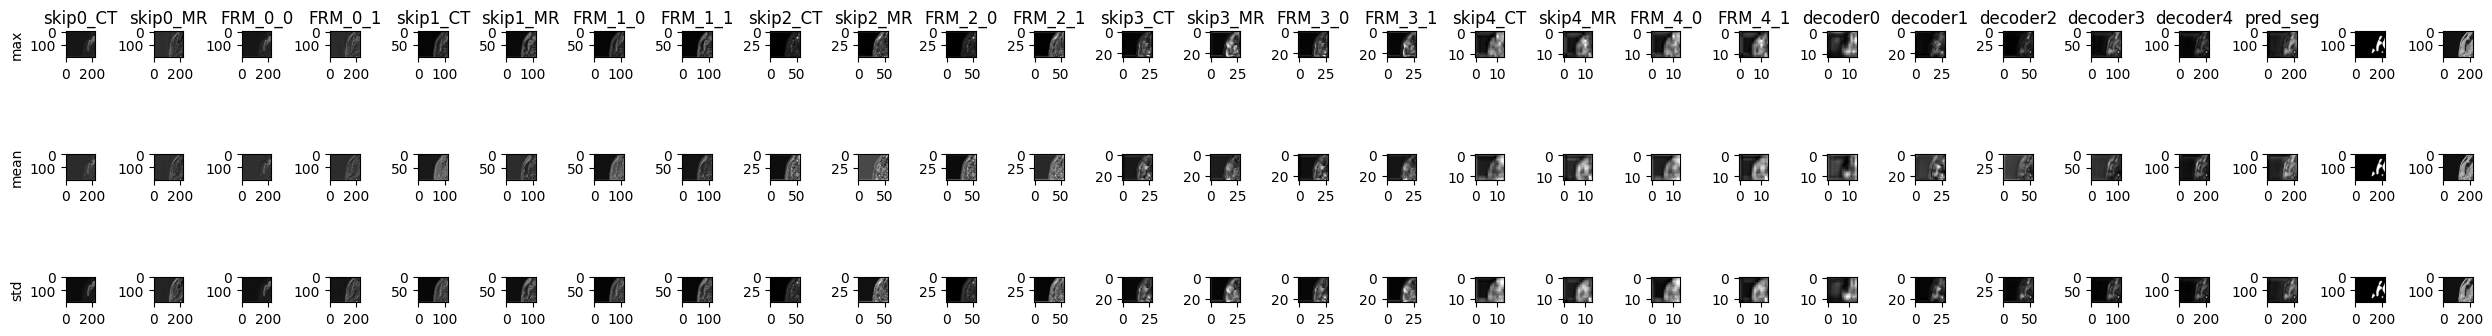

In [10]:
B = 0
SLC = 2

t = data['target'][0][B][0].cpu().numpy().astype(bool).astype(int)

plot(activation, t, B, SLC, d[0][1].cpu().numpy())

In [11]:
def setup_hooks(d):
    # Visualize feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            if isinstance(output, torch.Tensor):
                activation[name] = output.detach().cpu().numpy()
            elif isinstance(output, (tuple, list)):
                for enum, o in enumerate(output):
                    activation[name + f'_{enum}'] = o.detach().cpu().numpy()
            else:
                print(f'Unknown output type: {type(output)}')
        return hook

    hooks = []
    
    hooks.append(nnunet_trainer.network.encoder.FRMs[0].register_forward_hook(get_activation('FRM_0')))
    hooks.append(nnunet_trainer.network.encoder.FRMs[1].register_forward_hook(get_activation('FRM_1')))
    hooks.append(nnunet_trainer.network.encoder.FRMs[2].register_forward_hook(get_activation('FRM_2')))
    hooks.append(nnunet_trainer.network.encoder.FRMs[3].register_forward_hook(get_activation('FRM_3')))
    hooks.append(nnunet_trainer.network.encoder.FRMs[4].register_forward_hook(get_activation('FRM_4')))
    
    hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[0].register_forward_hook(get_activation('attn0')))
    hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[1].register_forward_hook(get_activation('attn1')))
    hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[2].register_forward_hook(get_activation('attn2')))
    hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[3].register_forward_hook(get_activation('attn3')))
    hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[4].register_forward_hook(get_activation('attn4')))

    # output = nnunet_trainer.network.encoder(d[:,[0]], d[:,[1]])
    nnunet_trainer.network.eval()
    output = nnunet_trainer.network(d)

    for h in hooks:
        h.remove()
        
    return activation

In [12]:
activation = setup_hooks(d)

for k in list(activation.keys()):
    if isinstance(activation[k], (list, tuple)):
        print(k, len(activation[k]), activation[k][0].shape)
    else:
        print(k, activation[k].shape)

FRM_0_0 (1, 32, 40, 192, 224)
FRM_0_1 (1, 32, 40, 192, 224)
attn0_0 (1, 32, 40, 192, 224)
attn0_1 (1, 32, 40, 192, 224)
FRM_1_0 (1, 64, 40, 96, 112)
FRM_1_1 (1, 64, 40, 96, 112)
attn1_0 (1, 64, 40, 96, 112)
attn1_1 (1, 64, 40, 96, 112)
FRM_2_0 (1, 128, 40, 48, 56)
FRM_2_1 (1, 128, 40, 48, 56)
attn2_0 (1, 128, 40, 48, 56)
attn2_1 (1, 128, 40, 48, 56)
FRM_3_0 (1, 256, 20, 24, 28)
FRM_3_1 (1, 256, 20, 24, 28)
attn3_0 (1, 256, 20, 24, 28)
attn3_1 (1, 256, 20, 24, 28)
FRM_4_0 (1, 320, 10, 12, 14)
FRM_4_1 (1, 320, 10, 12, 14)
attn4_0 (1, 320, 10, 12, 14)
attn4_1 (1, 320, 10, 12, 14)


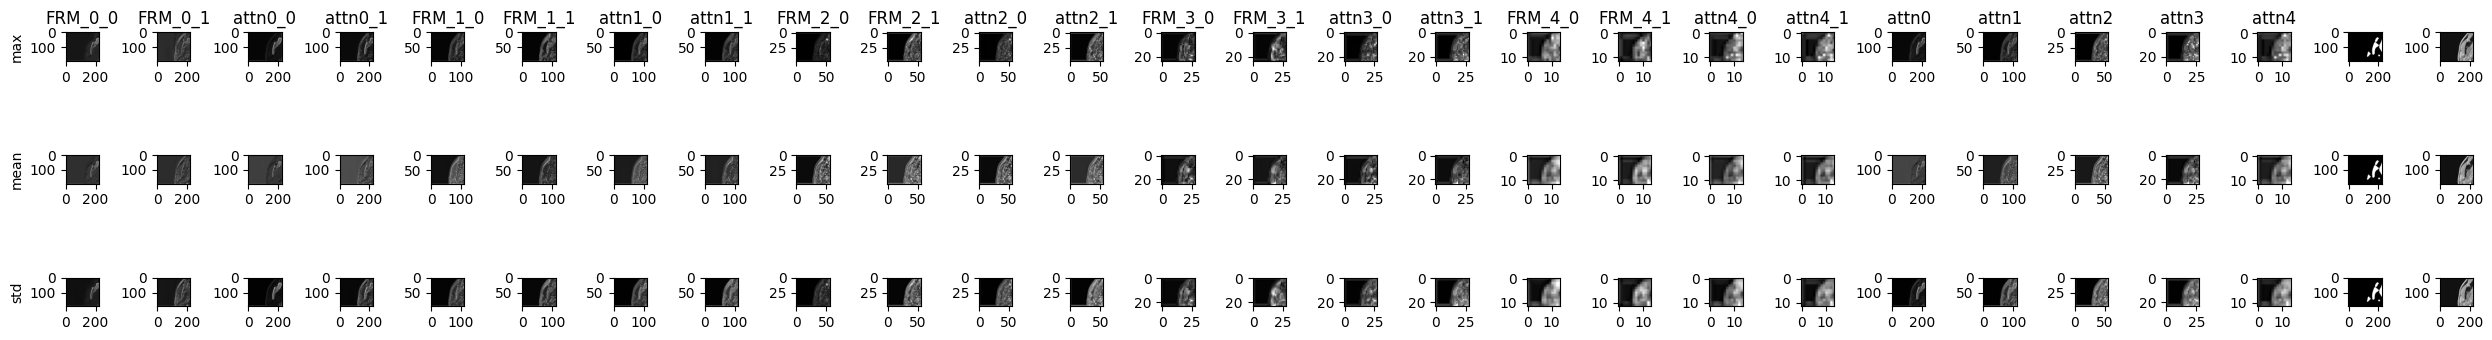

In [13]:
activation['attn0'] = activation['attn0_0'] + activation['attn0_1']
activation['attn1'] = activation['attn1_0'] + activation['attn1_1']
activation['attn2'] = activation['attn2_0'] + activation['attn2_1']
activation['attn3'] = activation['attn3_0'] + activation['attn3_1']
activation['attn4'] = activation['attn4_0'] + activation['attn4_1']

t = data['target'][0][B][0].cpu().numpy().astype(bool).astype(int)

plot(activation, t, B, SLC, d[0][1].cpu().numpy())

In [14]:
nnunet_trainer.network.encoder.FFMs_stage1[0].cross.heads[0]

EfficientCrossAttentionHeadV2(
  (key0): Linear(in_features=32, out_features=16, bias=False)
  (key1): Linear(in_features=32, out_features=16, bias=False)
  (query0): Linear(in_features=32, out_features=16, bias=False)
  (query1): Linear(in_features=32, out_features=16, bias=False)
  (value0): Linear(in_features=32, out_features=16, bias=False)
  (value1): Linear(in_features=32, out_features=16, bias=False)
)

In [15]:
nnunet_trainer.network.encoder.FFMs_stage1[0].cross.heads

ModuleList(
  (0-1): 2 x EfficientCrossAttentionHeadV2(
    (key0): Linear(in_features=32, out_features=16, bias=False)
    (key1): Linear(in_features=32, out_features=16, bias=False)
    (query0): Linear(in_features=32, out_features=16, bias=False)
    (query1): Linear(in_features=32, out_features=16, bias=False)
    (value0): Linear(in_features=32, out_features=16, bias=False)
    (value1): Linear(in_features=32, out_features=16, bias=False)
  )
)

In [16]:
def setup_hooks(d):
    # Visualize feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            if isinstance(output, torch.Tensor):
                activation[name] = output.detach().cpu().numpy()
            elif isinstance(output, (tuple, list)):
                for enum, o in enumerate(output):
                    activation[name + f'_{enum}'] = o.detach().cpu().numpy()
            else:
                print(f'Unknown output type: {type(output)}')
        return hook

    hooks = []
    
    for head in range(2):
        hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[0].cross.heads[head].key0.register_forward_hook(get_activation(f'h{head}_key0')))
        hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[0].cross.heads[head].key1.register_forward_hook(get_activation(f'h{head}_key1')))
        
        hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[0].cross.heads[head].value0.register_forward_hook(get_activation(f'h{head}_value0')))
        hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[0].cross.heads[head].value1.register_forward_hook(get_activation(f'h{head}_value1')))
        
        hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[0].cross.heads[head].query0.register_forward_hook(get_activation(f'h{head}_query0')))
        hooks.append(nnunet_trainer.network.encoder.FFMs_stage1[0].cross.heads[head].query1.register_forward_hook(get_activation(f'h{head}_query1')))
    
    hooks.append(nnunet_trainer.network.encoder.FRMs[0].register_forward_hook(get_activation('FRM_0')))
    

    # output = nnunet_trainer.network.encoder(d[:,[0]], d[:,[1]])
    nnunet_trainer.network.eval()
    output = nnunet_trainer.network(d)

    for h in hooks:
        h.remove()
        
    return activation

In [17]:
activation = setup_hooks(d)

for k in list(activation.keys()):
    if isinstance(activation[k], (list, tuple)):
        print(k, len(activation[k]), activation[k][0].shape)
    else:
        print(k, activation[k].shape)

FRM_0_0 (1, 32, 40, 192, 224)
FRM_0_1 (1, 32, 40, 192, 224)
h0_key0 (1, 1720320, 16)
h0_key1 (1, 1720320, 16)
h0_query0 (1, 1720320, 16)
h0_query1 (1, 1720320, 16)
h0_value0 (1, 1720320, 16)
h0_value1 (1, 1720320, 16)
h1_key0 (1, 1720320, 16)
h1_key1 (1, 1720320, 16)
h1_query0 (1, 1720320, 16)
h1_query1 (1, 1720320, 16)
h1_value0 (1, 1720320, 16)
h1_value1 (1, 1720320, 16)


In [18]:
h0k0 = torch.from_numpy(activation['h0_key0']).softmax(dim=-1).transpose(-2, -1)
h0k1 = torch.from_numpy(activation['h0_key1']).softmax(dim=-1).transpose(-2, -1)

h0v0 = torch.from_numpy(activation['h0_value0'])
h0v1 = torch.from_numpy(activation['h0_value1'])

h0q0 = torch.from_numpy(activation['h0_query0']).softmax(dim=-2)
h0q1 = torch.from_numpy(activation['h0_query1']).softmax(dim=-2)

h1k0 = torch.from_numpy(activation['h1_key0']).softmax(dim=-1).transpose(-2, -1)
h1k1 = torch.from_numpy(activation['h1_key1']).softmax(dim=-1).transpose(-2, -1)

h1v0 = torch.from_numpy(activation['h1_value0'])
h1v1 = torch.from_numpy(activation['h1_value1'])

h1q0 = torch.from_numpy(activation['h1_query0']).softmax(dim=-2)
h1q1 = torch.from_numpy(activation['h1_query1']).softmax(dim=-2)

In [19]:
h0k0.sum(-2)

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])

In [20]:
h0w0 = h0k0 @ h0v0
h0w1 = h0k1 @ h0v1

h0attn_x0 = h0q0 @ h0w1
h0attn_x1 = h0q1 @ h0w0


h1w0 = h1k0 @ h1v0
h1w1 = h1k1 @ h1v1

h1attn_x0 = h1q0 @ h1w1
h1attn_x1 = h1q1 @ h1w0

h0w0.shape, h0attn_x0.shape, h0w1.shape, h0attn_x1.shape

(torch.Size([1, 16, 16]),
 torch.Size([1, 1720320, 16]),
 torch.Size([1, 16, 16]),
 torch.Size([1, 1720320, 16]))

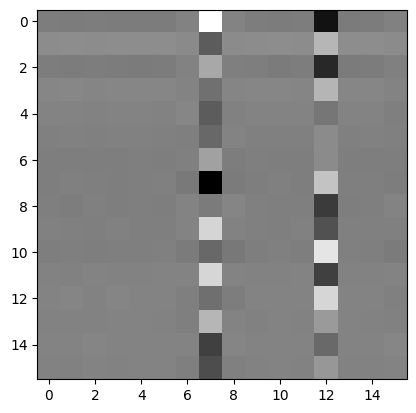

In [21]:
plt.imshow((h0w0/h0w0.sum(1))[0].cpu().numpy(), cmap='gray')

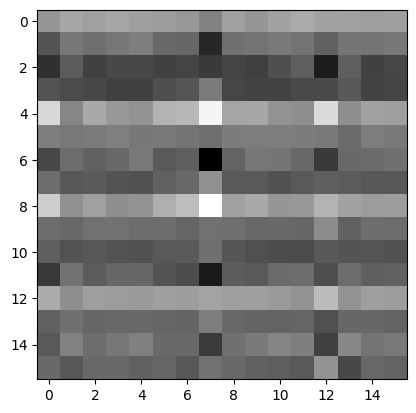

In [22]:
plt.imshow((h1w0/h1w0.sum(1))[0].cpu().numpy(), cmap='gray')

In [23]:
(w0/w0.sum(1))[0]

NameError: name 'w0' is not defined

In [ ]:
w0[0].mean(0), w0[0].std(0)

In [ ]:
w0[0].cpu().numpy().round(2)[:,:4]

In [ ]:
w0[0].cpu().numpy().round(2)[:,7]

In [ ]:
h0attn_x1.shape

In [ ]:
attn_x1 = torch.cat([h0attn_x1, h1attn_x1], dim=-1)
attn_x1.shape

In [ ]:
attn_x1.mean(1)
print(attn_x1.shape)
plt.bar(range(32), attn_x1.mean(1)[0].cpu().numpy())

In [ ]:
activation['FRM_0_1'].reshape(1, 32, -1).mean(-1)

In [ ]:
plt.bar(range(32), activation['FRM_0_1'].reshape(1, 32, -1).mean(-1)[0])

In [ ]:
kk0 = torch.randn(1, 1720320, 16).softmax(dim=-1).transpose(-2, -1)
vv0 = torch.randn(1, 1720320, 16)
qq1 = torch.randn(1, 1720320, 16).softmax(dim=-2)

ww0 = kk0 @ vv0
plt.imshow(ww0[0].cpu().numpy(), cmap='gray')

In [ ]:
plt.imshow(attn_x0[0].transpose(-2,-1).reshape(16, 40, 192, 224).cpu().numpy().max(0)[0], cmap='gray')

In [ ]:
w0[0].cpu().numpy().round(2)

In [ ]:
attn_x1.shape, attn_x1.transpose(-2, -1).shape, attn_x1.transpose(-2, -1)[0].reshape(16, 40, 192, 224).shape

In [ ]:
plot_q1 = q1.transpose(-2, -1)[0].reshape(16, 40, 192, 224)
fig, axes = plt.subplots(4,4, figsize=(15, 15))
axes = axes.ravel()
SLC = 0
vmin, vmax = plot_q1[:, SLC].min().item(), plot_q1[:, SLC].max().item()
for i in range(16):
    axes[i].imshow(plot_q1[i][SLC].cpu().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
    axes[i].set_title(f'head {i}')

In [ ]:
attended_x1 = attn_x1.transpose(-2, -1)[0].reshape(16, 40, 192, 224)
fig, axes = plt.subplots(4,4, figsize=(15, 15))
axes = axes.ravel()
vmin, vmax = attended_x1[:, SLC].min().item(), attended_x1[:, SLC].max().item()
print(vmin, vmax)
for i in range(16):
    axes[i].imshow(attended_x1[i][SLC].cpu().numpy(), cmap='gray')#, vmin=vmin, vmax=vmax)
    # axes[i].hist(attended_x1[i][SLC].cpu().numpy().flatten()) #, vmin=vmin, vmax=vmax)
    axes[i].set_title(f'head {i}')

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15, 15))
axes[0].imshow(plot_q1.cpu().numpy().max(0)[SLC], cmap='gray')
axes[1].imshow(attended_x1.cpu().numpy().max(0)[SLC], cmap='gray')

In [ ]:
plt.imshow(np.random.randn(10, 1000) @ np.random.randn(10, 1000).T)

In [ ]:
kk = torch.randn(1000, 10)
qq = torch.randn(1000, 10)

In [ ]:
torch.nn.functional.softmax(qq @ kk.T, dim=0).sum(0)

In [ ]:
(torch.nn.functional.softmax(qq, dim=0) @ torch.nn.functional.softmax(kk, dim=1).T).sum(0)

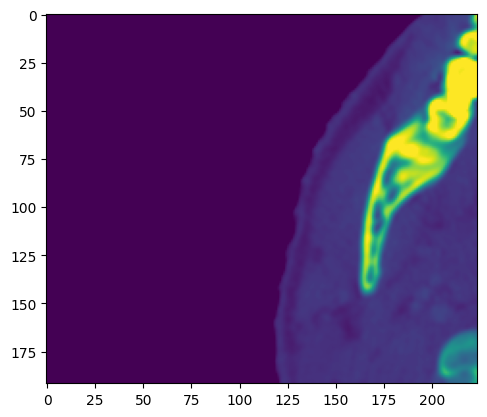

In [26]:
plt.imshow(d[0,0,0].cpu().cpu().numpy())

In [35]:
d.shape, d[0,[0],[0]].shape

(torch.Size([1, 2, 40, 192, 224]), torch.Size([1, 192, 224]))

In [39]:
from einops.layers.torch import Rearrange
img = d[0,[0],[0]][None]
print(img.shape)
patch_height, patch_width = 64, 32

torch.Size([1, 1, 192, 224])


In [41]:
patched = Rearrange('b c (h p1) (w p2) -> b (h w) p1 p2 c', p1 = patch_height, p2 = patch_width)(img)
patched.shape

torch.Size([1, 21, 64, 32, 1])

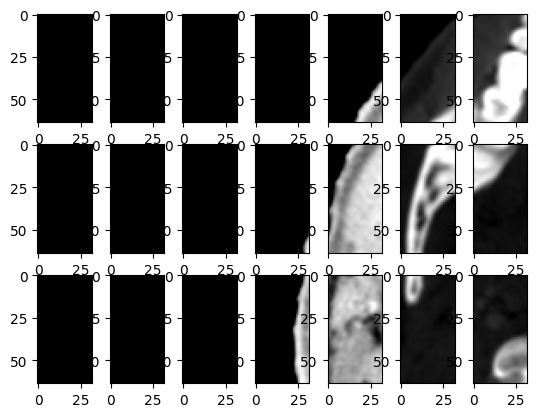

In [42]:
fig, axes = plt.subplots(3, 7)
axes = axes.ravel()
for i in range(21):
    axes[i].imshow(patched[0, i, ..., 0].cpu().numpy(), cmap='gray')